# Orthogonalized vector space tutorial

In this tutorial you will learn:


- How to construct a vector space that is orthonormal in a custom inner product

## Modules
Here are the relevant modules for this example.

In [8]:
%%capture
import romtools
import numpy as np
from matplotlib import pyplot as plt
from romtools import vector_space

## Snapshots
First, we load in snapshots from a FOM. We use pre-computed snapshots of the [1D Euler equations](https://pressio.github.io/pressio-demoapps/euler_1d_smooth.html) obtained using pressio-demo-apps.

In [9]:
snapshots = np.load('snapshots.npz')['snapshots']

# The snapshots are in tensor form:
n_vars, nx, nt = snapshots.shape

Note that romtools works with [tensor forms](https://pressio.github.io/rom-tools-and-workflows/romtools/vector_space.html).

As an example, we want to create a basis that is orthonormal w.r.p. to the cell volumes.
In this example, the cell volume was `dx = 1/500`.

In [10]:
# Set dx
dx = 1./500

We will create a vector the size of a single snapshot that we wish to orthogonalize against.

In [11]:
w = np.ones(snapshots[...,0].size)*dx

## Basis Creation
This section goes over creating the basis.

First, we create an [orthogonalizer](https://pressio.github.io/rom-tools-and-workflows/romtools/vector_space/utils/orthogonalizer.html).

In [12]:
my_orthogonalizer = vector_space.utils.EuclideanVectorWeightedL2Orthogonalizer(w)

Like the last tutorial, let's create a [truncater](https://pressio.github.io/rom-tools-and-workflows/romtools/vector_space/utils/truncater.html) that controls for how we want to truncate our basis. This truncater is set to truncate the number of modes to capture 99.9% of the cumulative energy.

In [13]:
my_truncater = vector_space.utils.EnergyBasedTruncater(0.999)

Now, let's construct a vector space using POD with our truncater and orthogonalizer

In [14]:
my_vector_space = vector_space.VectorSpaceFromPOD(snapshots,truncater=my_truncater,orthogonalizer=my_orthogonalizer)

We do not do a deep copy of the snapshot matrix for performance reasons. Once a snapshot tensor is passed, we modify the data in place. 

We can grab the basis and shift vector from our defined `VectorSpace` function.

In [15]:
basis = my_vector_space.get_basis()
shift_vector = my_vector_space.get_shift_vector()

Now, let us view the first basis mode for density.

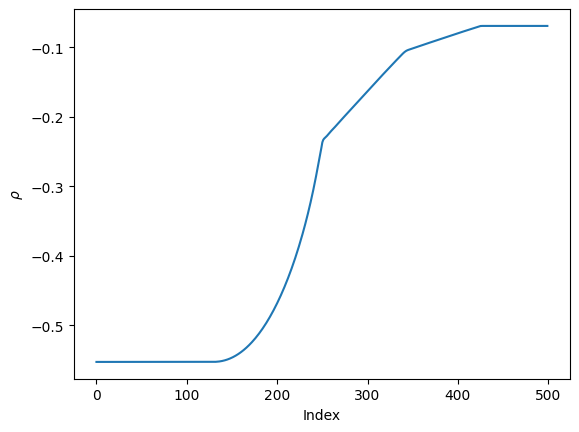

In [16]:
#We can look at the density component of the first basis:
plt.plot(basis[0,:,0])
plt.xlabel(r'Index')
plt.ylabel(r'$\rho$')
plt.show()

We can also check whether the basis is orthonormal in the desired inner product.

In [17]:
w = w.reshape(basis[...,0].shape)
is_identity = np.einsum('ijk,ij,ijl->kl',basis,w,basis)
assert(np.allclose(is_identity,np.eye(my_vector_space.extents()[-1])))